In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import tensorflow as tf
from keras.models import load_model

import warnings

from mlprecip_utils import *
from mlprecip_models import *
#from mlprecip_datasets import *
from mlprecip_xai import *
from mlprecip_plot import *

import mlprecip_datasets

# Turn off deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

warnings.filterwarnings("ignore")


from numpy.random import seed
seed(1)

/homes/kpegion/.conda/envs/h5py-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/h5py-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/h5py-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion/.conda/envs/h5py-test/lib

In [2]:
def make_cm(Ypred,Y):
    
    f, ax = pplt.subplots(ncols=1,nrows=1)
    tp=np.count_nonzero(~np.isnan(np.where(np.logical_and(Ypred==Y,Ypred==1))))
    tn=np.count_nonzero(~np.isnan(np.where(np.logical_and(Ypred==Y,Ypred==0))))
    fp=np.count_nonzero(~np.isnan(np.where(np.logical_and(Ypred!=Y,Ypred==1))))
    fn=np.count_nonzero(~np.isnan(np.where(np.logical_and(Ypred!=Y,Ypred==0))))
    array=[[fn,tp],
           [tn,fp]]
    df = pd.DataFrame(array, ['Negative','Positive'], ['Positive','Negative'])
    ax.heatmap(df,labels=True,cmap='viridis') 
    ax.format(ylabel='True',xlabel='Predicted')
    
    return

In [3]:
def init_predictors_dict():
    
    amo_dict=dict(name='amo',ptype='index',freq='mon',readfunc='getMonthlyClimIndices',
                 file='/data/ccsm4/kpegion/obs2/CLIM_INDICES/amo.txt')
    naomonthly_dict=dict(name='nao',ptype='index',freq='mon',readfunc='getMonthlyClimIndices',
                        file='/data/ccsm4/kpegion/obs2/CLIM_INDICES/nao.txt')
    nino34_dict=dict(name='nino34',ptype='index',freq='mon',readfunc='getMonthlyClimIndices',
                    file='/data/ccsm4/kpegion/obs2/CLIM_INDICES/nino34.txt')
    pdo_dict=dict(name='pdo',ptype='index',freq='mon',readfunc='getMonthlyClimIndices',
                 file='/data/ccsm4/kpegion/obs2/CLIM_INDICES/pdo.txt')
    rmmamp_dict=dict(name='RMM_amp',ptype='index',freq='day',readfunc='getRMM',
                     file='/data/ccsm4/kpegion/obs2/RMM/rmmint1979-092021.txt')
    rmmphase_dict=dict(name='RMM_phase',ptype='cat',freq='day',readfunc='getRMM',
                      file='/data/ccsm4/kpegion/obs2/RMM/rmmint1979-092021.txt')
    pnaregimes_dict=dict(name='pnaregimes',ptype='cat',freq='day',readfunc='getWR',
                         file='/scratch/kpegion/ERAI_clusters_5_1980-2015_')
    mlso_dict=dict(name='mlso',ptype='index',freq='day',readfunc='getMLSO',
                  file='/data/vortex/scratch/mlso.index.01011979-08312019.nc')
    nashamp_dict=dict(name='nash_amp',ptype='index',freq='day',readfunc='getNASH',
                      file='/scratch/kpegion/ERAI_NASH_JJA.1979-2019.nc')
    nashphase_dict=dict(name='nash_phase',ptype='cat',freq='day',readfunc='getNASH',
                        file='/scratch/kpegion/ERAI_NASH_JJA.1979-2019.nc')
    z500local_dict=dict(name='z500_local',ptype='index',freq='day',readfunc='getz500_local',
                        file='/project/predictability/kpegion/wxregimes/era-interim/erai_z500_1979-2019.nc')

    #predictors=[amo_dict,nino34_dict,pdo_dict]
    #predictors=[rmmamp_dict,rmmphase_dict,mlso_dict,nashphase_dict,naomonthly_dict]
    #predictors=[mlso_dict,naomonthly_dict,nashphase_dict]
    predictors=[amo_dict,naomonthly_dict,nino34_dict,pdo_dict,rmmamp_dict,rmmphase_dict,mlso_dict,
                pnaregimes_dict,nashphase_dict,nashamp_dict]

    return predictors

In [4]:
summer=[6,7,8]
sdate='1979-01-01'
edate='2018-12-31'
lat_reg=[24.0,36.0]
lon_reg=[269.0,283.0]
varname='precip'

### Load Model

modelnum=0
model_file='../data/fnn/logmodel_med.med_seus.'+str(modelnum)+'.h5'
print(model_file)

model = load_model(model_file)

### Target

In [5]:
fnames='/shared/ccsm4/kpegion/obs2/CPC-UNI/precip.V1.0.*.nc'
ds=xr.open_mfdataset(fnames,combine='by_coords').sel(time=slice(sdate,edate))

# Subset to SEUS
ds_seus=ds.sel(lat=slice(lat_reg[0],lat_reg[1]),lon=slice(lon_reg[0],lon_reg[1]))

# Calculate Anomalies
ds_anoms=ds_seus.groupby('time.dayofyear')-ds_seus.groupby('time.dayofyear').mean()

ds_anoms

<xarray.Dataset>
Dimensions:    (lat: 48, lon: 56, time: 14610)
Coordinates:
  * lat        (lat) float32 24.12 24.38 24.62 24.88 ... 35.12 35.38 35.62 35.88
  * lon        (lon) float32 269.1 269.4 269.6 269.9 ... 282.1 282.4 282.6 282.9
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Data variables:
    precip     (time, lat, lon) float32 dask.array<chunksize=(1, 48, 56), meta=np.ndarray>

### Get Features

In [6]:
indices_dict=init_predictors_dict()

# Loop over seasons
for seas,slabel,seas_abbrv in zip([summer],['Summer'],['JJA']):

    print(slabel)
        
    features_list=[]
    
    # Loop over all indices
    for i,f in enumerate(indices_dict):

        # Read the Indices
        if (f['ptype']=='index' and f['freq']=='mon'):
            ds=getattr(mlprecip_datasets,f['readfunc'])(f['file'],f['name'],sdate,edate)
            # Linearly interpolate monthly indices to daily
            ds=ds.resample(time='1D').interpolate("linear").sel(time=slice(sdate,edate))
        elif (f['name']=='RMM_amp'):
            _,ds=getattr(mlprecip_datasets,f['readfunc'])(f['file'],sdate,edate)
        elif (f['name']=='RMM_phase'):
            ds,_=getattr(mlprecip_datasets,f['readfunc'])(f['file'],sdate,edate)
        elif (f['name']=='pnaregimes'): 
            ds=getattr(mlprecip_datasets,f['readfunc'])(f['file'],seas_abbrv,sdate,edate)
        elif (f['name']=='nash_amp'):
            _,ds=getattr(mlprecip_datasets,f['readfunc'])(f['file'],sdate,edate)
        elif (f['name']=='nash_phase'):
            ds,_=getattr(mlprecip_datasets,f['readfunc'])(f['file'],sdate,edate)
        elif (f['name']=='z500_local'):
            print("skipping z500_local")
            ds=getattr(mlprecip_datasets,f['readfunc'])(f['file'],lat_reg,lon_reg,sdate,edate)
        else:
            ds=getattr(mlprecip_datasets,f['readfunc'])(f['file'],sdate,edate)
        
        # Standardize indices that are not categorical
        if (f['ptype']=='index'):
            v=f['name']
            ds[v]=(ds[v]-ds[v].mean(dim='time'))/ds[v].std(dim='time')
        
        # Select season from predictor index and target index
        ds_i=ds.sel(time=ds['time.month'].isin(seas)) #.dropna(dim='time')        
        ds_p=ds_anoms.sel(time=ds_anoms['time.month'].isin(seas)).sel(time=slice(sdate,edate)) #.dropna(dim='time')
        
        # Append this predictor index to list of all predictors
        features_list.append(ds_i[f['name']])

#----- FIT MODELS AND TEST  -----------#
    
    # Define Features
    ds_features=xr.merge(features_list).dropna(dim='time')   
    
    # Define Index Target as Mean precip in region
    # Note this is currently designed as a diagnostic not a real prediction; add target lead for prediction
    ds_target=ds_p.mean(dim=['lat','lon'])
    
    # Make sure we have the same times for target and features
    ds_target,ds_features=xr.align(ds_target,ds_features,join='inner')
    
    # Center data
    median=np.percentile(ds_target[varname],50)
    ds_target[varname]=ds_target[varname]-median
        

Summer


In [7]:
# Setup Features (X) and Target (Y)
    
X=ds_features.to_stacked_array('features',sample_dims=['time'])
Y=make_ohe_thresh_med(ds_target[varname])

print('Check Features and Target Dimensions')
print('Features (X): ',X.shape)
print('Target (Y): ',Y.shape)

nsamples=X.shape[0]
nfeatures=X.shape[1]

print("Samples: ",nsamples)
print("Features: ", nfeatures)
    
# Create Train and Test Sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8,shuffle=False)

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

print('Training Size: ',ntrain)
print('Testing Size: ',ntest)    

Upper Cat:  1502
Lower Cat:  1502
Check Features and Target Dimensions
Features (X):  (3004, 10)
Target (Y):  (3004, 2)
Samples:  3004
Features:  10
Training Size:  2403
Testing Size:  601


### Neural Network

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
nnmodel = KerasClassifier(build_fn=nnmodel_med(X_train.shape[1]),epochs=250,batch_size=25, verbose=1,callbacks=[es])
history=nnmodel.fit(X_train,Y_train,validation_data=(X_test,Y_test))

Train on 2403 samples, validate on 601 samples
Epoch 1/250
 850/2403 [=========>....................] - ETA: 0s - loss: 2.2542 - acc: 0.4976 

2021-10-29 17:39:00.193705: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2021-10-29 17:39:00.198751: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2399995000 Hz
2021-10-29 17:39:00.199679: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5558d9af1710 executing computations on platform Host. Devices:
2021-10-29 17:39:00.199718: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


2403/2403 [==============================] - 0s 133us/step - loss: 2.1460 - acc: 0.5194 - val_loss: 2.0994 - val_acc: 0.4576
Epoch 2/250
2403/2403 [==============================] - 0s 71us/step - loss: 2.0475 - acc: 0.5173 - val_loss: 2.0229 - val_acc: 0.4609
Epoch 3/250
2403/2403 [==============================] - 0s 71us/step - loss: 1.9506 - acc: 0.5148 - val_loss: 1.9490 - val_acc: 0.4559
Epoch 4/250
2403/2403 [==============================] - 0s 70us/step - loss: 1.8558 - acc: 0.5185 - val_loss: 1.8766 - val_acc: 0.4559
Epoch 5/250
2403/2403 [==============================] - 0s 70us/step - loss: 1.7633 - acc: 0.5210 - val_loss: 1.8027 - val_acc: 0.4626
Epoch 6/250
2403/2403 [==============================] - 0s 71us/step - loss: 1.6746 - acc: 0.5194 - val_loss: 1.7331 - val_acc: 0.4592
Epoch 7/250
2403/2403 [==============================] - 0s 70us/step - loss: 1.5894 - acc: 0.5185 - val_loss: 1.6664 - val_acc: 0.4493
Epoch 8/250
2403/2403 [==============================] - 0s

In [9]:
nnmodel.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


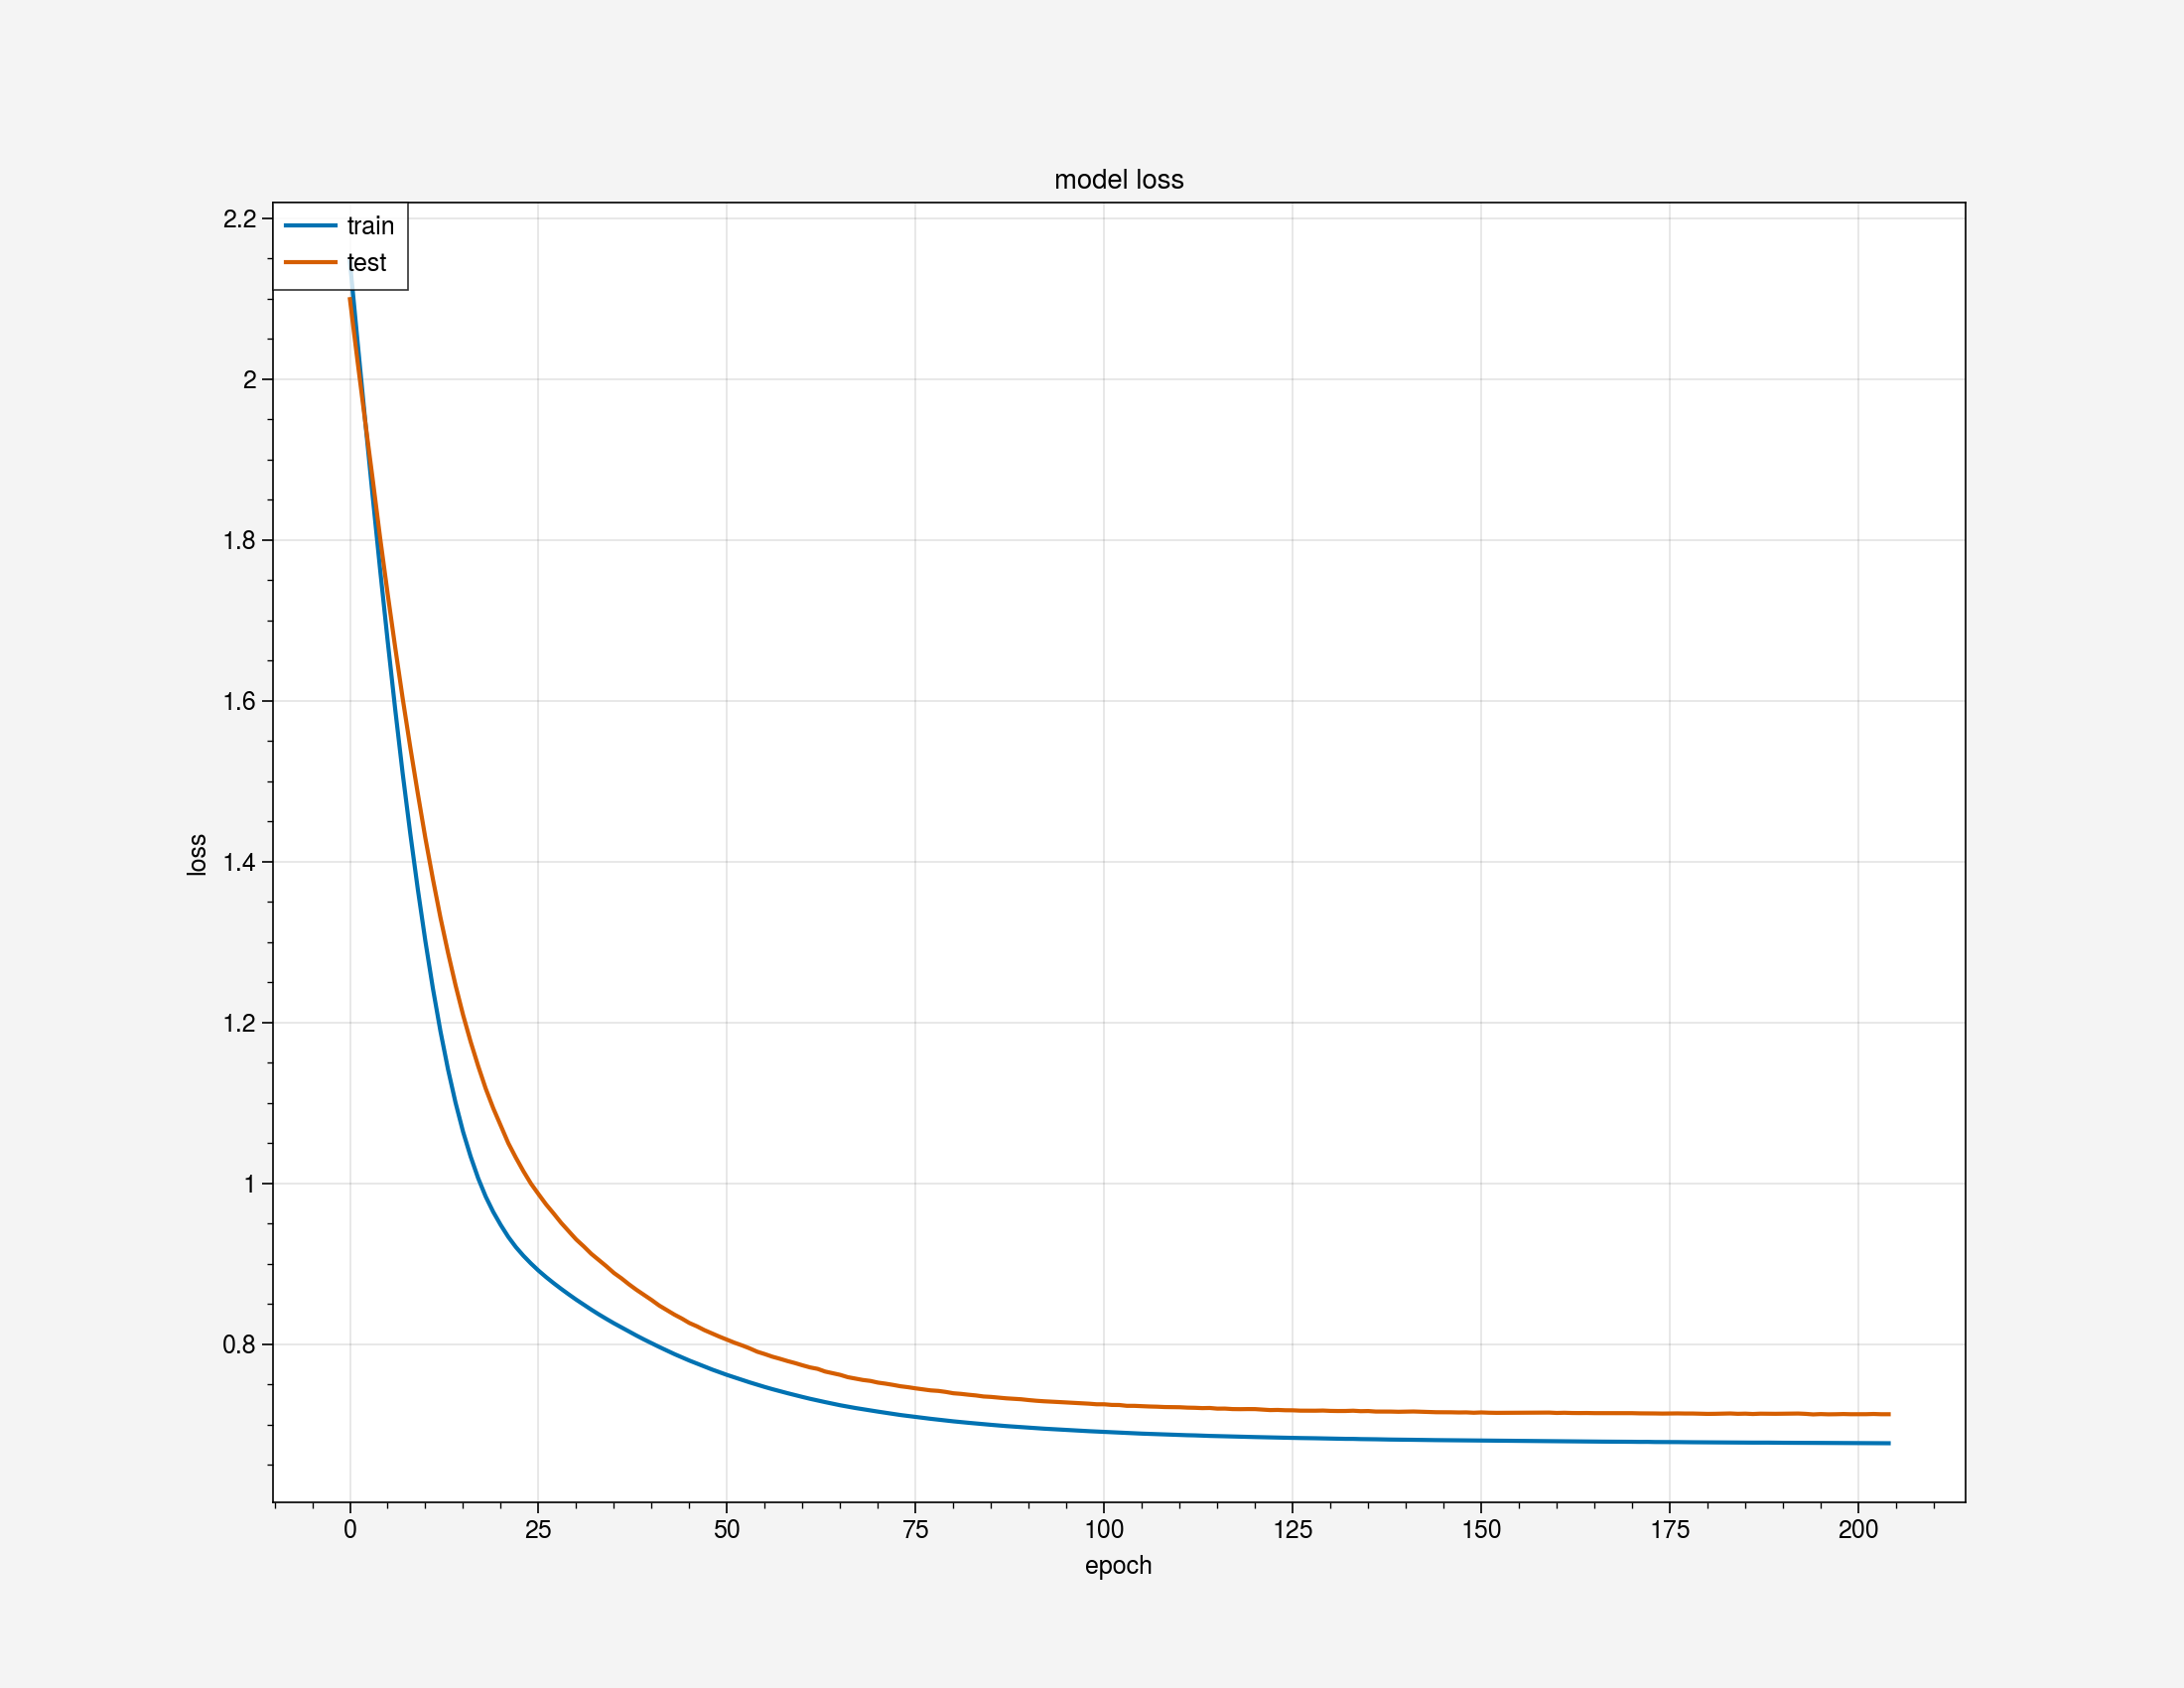

In [10]:
# Plot learning Curve for NN
plt.figure(figsize=(11,8.5))
plotLearningCurve(history)

3004/3004 [==============================] - 0s 42us/step


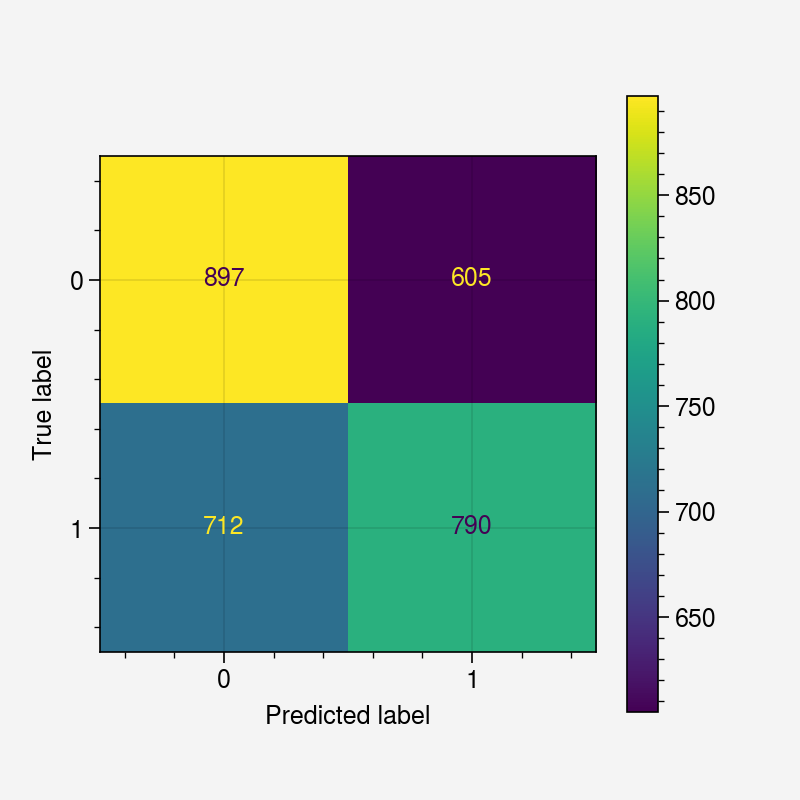

In [11]:
Ypred=nnmodel.predict(X)
cm = confusion_matrix(np.argmax(Y,axis=1), Ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

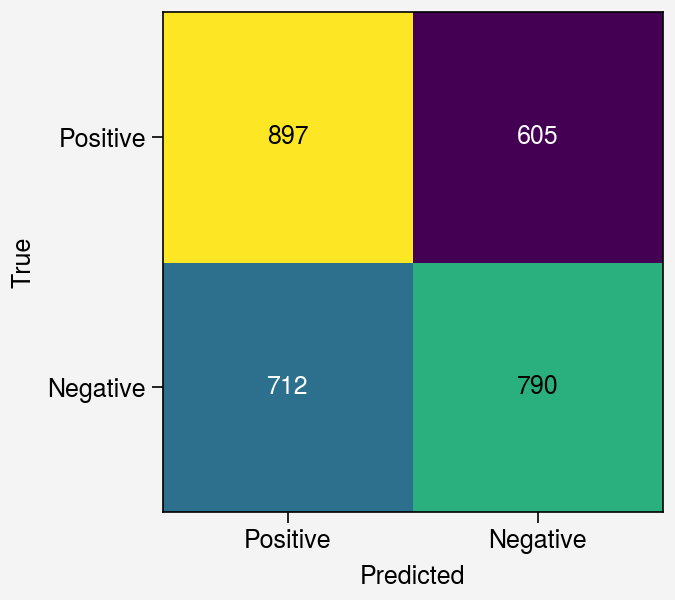

In [12]:
make_cm(Ypred,np.argmax(Y,axis=1))

[[-0.03646693 -0.16592126 -0.41853228 -0.14009319]
 [-0.1618919  -0.63744545  0.23438038 -0.09946612]
 [-0.19669925 -0.52046824  0.7019303   0.17606987]
 [ 0.00547578 -0.18785703 -0.01108233  0.12649566]
 [-0.1902132  -0.49343744 -0.02571073 -0.0398686 ]
 [-0.16074245  0.03121061  0.6312851   0.5795864 ]
 [ 0.23230712  0.09388868  0.12899965  0.44805443]
 [-0.22884478 -0.56305254 -0.11412366 -0.1802801 ]
 [ 0.07234433 -0.6788776  -0.15254319  0.4904035 ]
 [ 0.5138037   0.36915514  0.38586688  0.4358035 ]]
['amo', 'nao', 'nino34', 'pdo', 'RMM_amp', 'RMM_phase', 'mlso', 'pnaregimes', 'nash_phase', 'nash_amp']


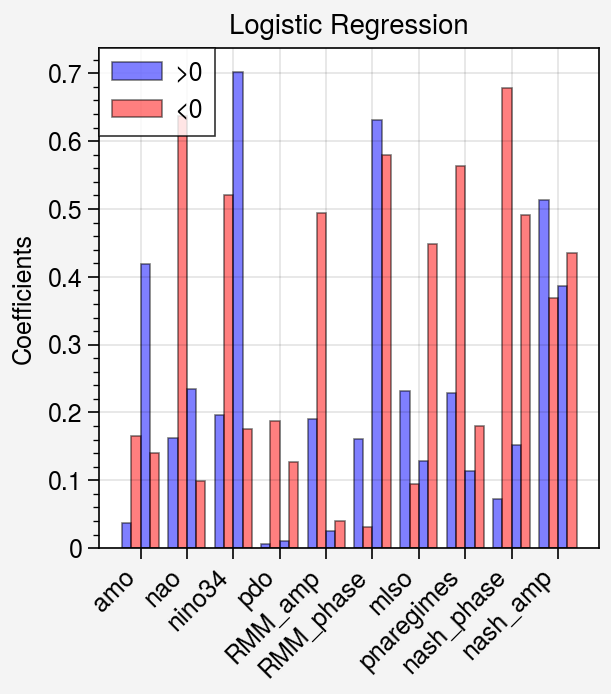

In [13]:
weights=np.asarray(nnmodel.model.layers[0].get_weights()[0])
print(weights)
print(list(ds_features.keys()))
f,ax=pplt.subplots(ncols=1,nrows=1)
hs=ax.bar(list(ds_features.keys()),np.abs(weights),cycle=['b','r'],edgecolor='k',alpha=0.5)
#ax.bar(list(ds_features.keys()),weights[:,1],color='r',edgecolor='k',alpha=0.7)
ax.format(xrotation=45,ylabel='Coefficients',title='Logistic Regression')
ax.legend(hs,labels=['>0','<0'],ncols=1,loc='ul')

### Test different LRP rules 

rules=['lrp.z','lrp.epsilon','lrp.alpha_1_beta_0'] #,'lrp.alpha_2_beta_1','lrp.z_IB','lrp.epsilon_IB']
X=ds_features.to_stacked_array('features',sample_dims=['time'])
lrp_list=[]
for r in rules:
    a=calcLRP(nnmodel.model,X,r)
    ds=xr.DataArray(a.reshape(X.shape[0],X.shape[1]),
                    coords={'time':ds_features['time'],
                            'features':list(ds_features.keys())},
                    dims=['time','features'])        
    ds=ds.to_dataset(name=r)
    lrp_list.append(ds)
    
ds_lrp=xr.merge(lrp_list)

In [14]:
rules=['lrp.z','lrp.epsilon','lrp.alpha_1_beta_0','lrp.alpha_2_beta_1','lrp.z_IB','lrp.epsilon_IB']
X=ds_features.to_stacked_array('features',sample_dims=['time'])
lrp_list=[]

a=calcLRP(nnmodel.model,X,rules)
print(np.asarray(a).shape)
ds=xr.DataArray(np.asarray(a).reshape(len(rules),X.shape[0],X.shape[1]),
                coords={'rule': rules,'time':ds_features['time'],
                        'features':list(ds_features.keys())},
                dims=['rule','time','features'])        
ds_lrp=ds.to_dataset(name='lrp')

(6, 3004, 10)


In [15]:
print(ds_lrp['lrp'].sel(rule='lrp.z'))

<xarray.DataArray 'lrp' (time: 3004, features: 10)>
array([[ 0.01217515, -0.01289341, -0.0078817 , ...,  0.1455706 ,
        -0.29698926,  0.16338633],
       [-0.0107806 ,  0.01069645,  0.00718238, ..., -0.03246292,
         0.26491994, -0.12750283],
       [-0.01070073,  0.00989173,  0.00733414, ..., -0.03246292,
         0.26491994, -0.09114198],
       ...,
       [ 0.04020268, -0.0166369 , -0.00521199, ...,  0.14557062,
        -0.29698926,  0.04415265],
       [-0.0357657 ,  0.01230588,  0.00502275, ..., -0.1298517 ,
         0.26491994, -0.04005142],
       [ 0.03998781, -0.01095419, -0.00604955, ...,  0.14557062,
        -0.19799285,  0.06043984]], dtype=float32)
Coordinates:
    rule      <U18 'lrp.z'
  * time      (time) datetime64[ns] 1980-06-03 1980-06-04 ... 2014-08-29
  * features  (features) <U10 'amo' 'nao' 'nino34' ... 'nash_phase' 'nash_amp'


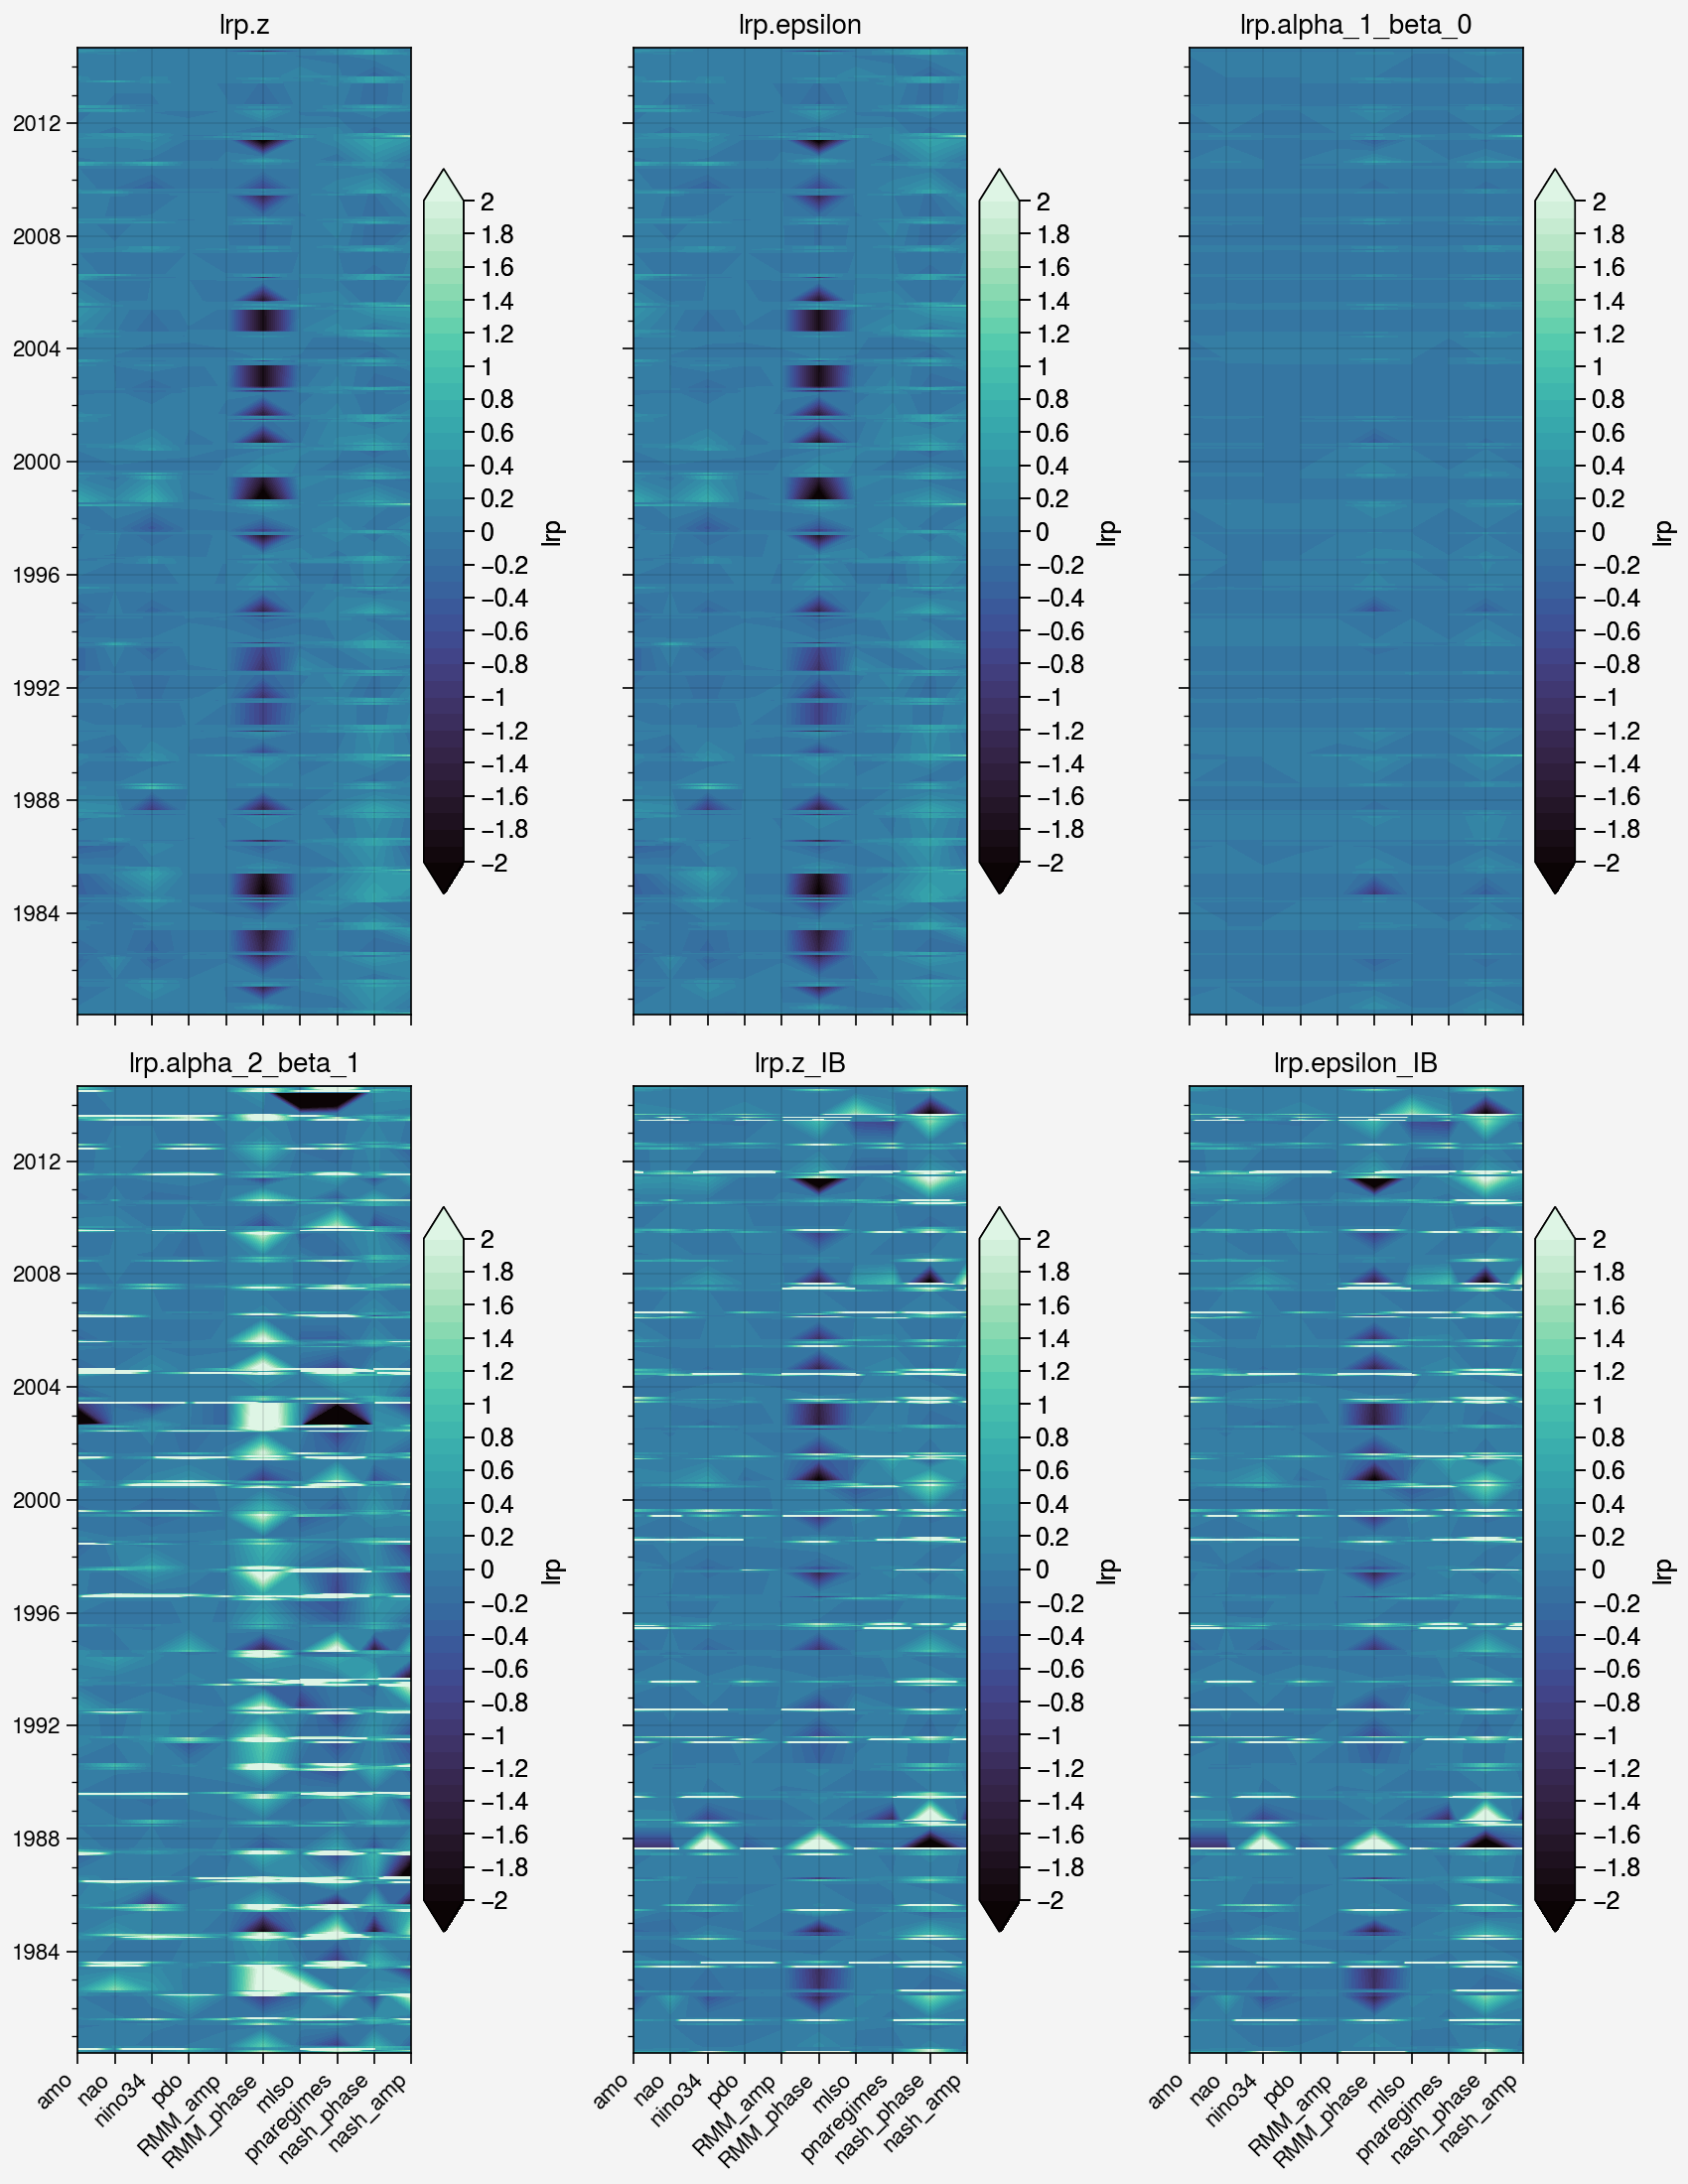

In [16]:
levs=np.arange(-2,2.1,0.1)
f, axs = pplt.subplots(ncols=3,nrows=2,figsize=(8.5,11))

for i,(ax,r) in enumerate(zip(axs,rules)):
    
    m=ax.contourf(ds_lrp['features'].values,ds_lrp['time'],ds_lrp['lrp'].sel(rule=r),levels=levs,extend='both',cmap='mako')
    ax.format(title=r,xrotation=45,fontsize=8)
    ax.colorbar(m,loc='r',length=0.75)

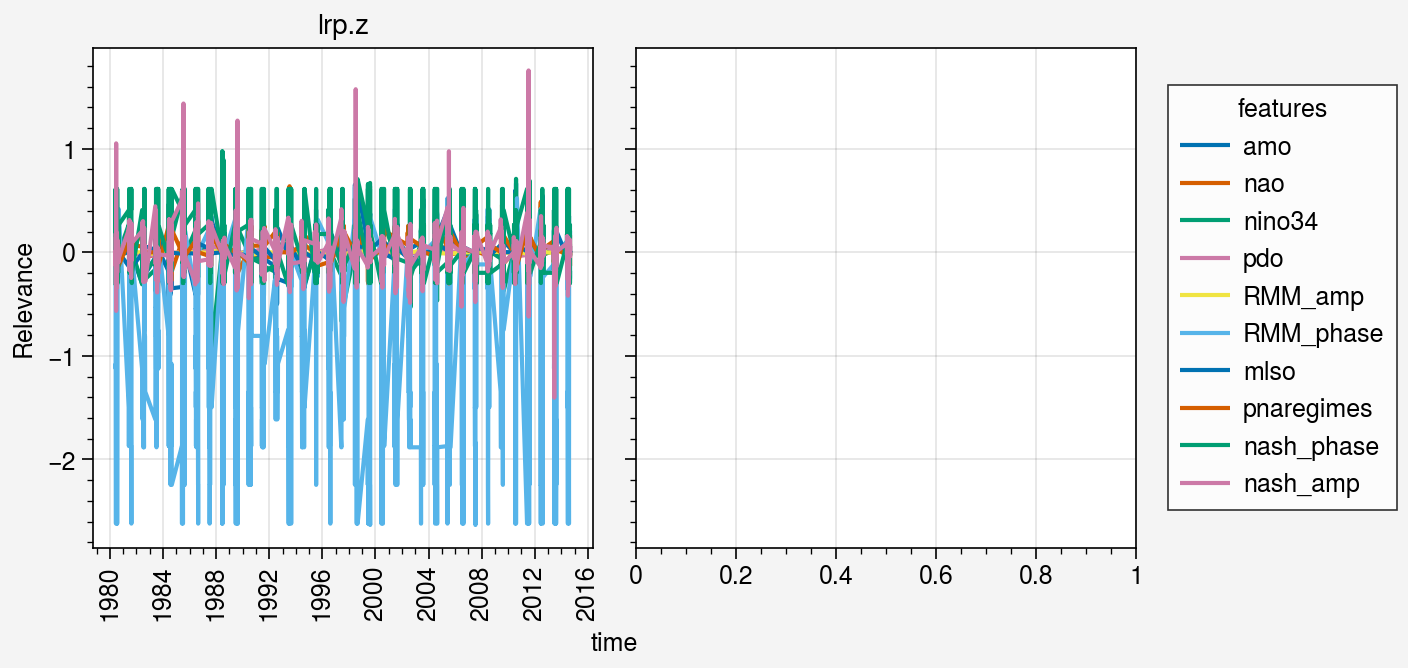

In [17]:
f,axs=pplt.subplots(ncols=2,nrows=1)
#rules2=['lrp.z','lrp.alpha_1_beta_0']
rules2=['lrp.z']
for ax,r in zip(axs,rules2):
    hs=ax.plot(ds_lrp['time'],ds_lrp['lrp'].sel(rule=r))
    ax.format(title=r,ylabel='Relevance')
f.legend(hs,labels=ds_lrp['features'].values,loc='right',ncols=1)

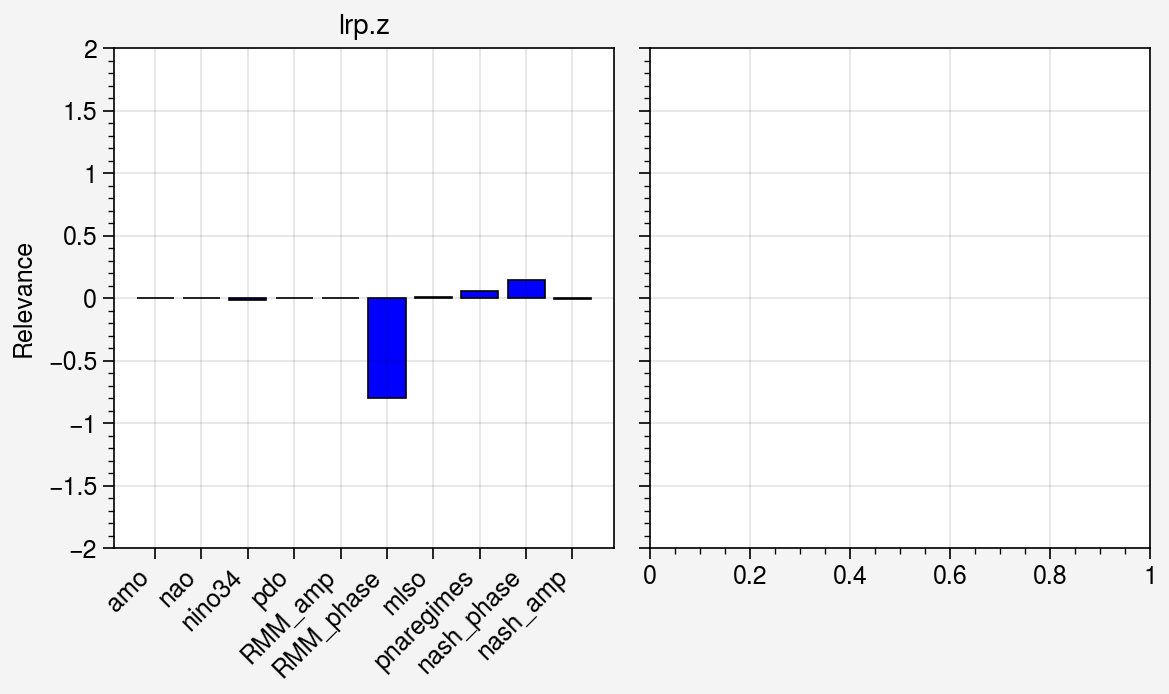

In [18]:
f,axs=pplt.subplots(ncols=2,nrows=1)
for ax,r in zip(axs,rules2):
    x=ds_lrp['features'].values
    y1=ds_lrp['lrp'].sel(rule=r).mean(dim=['time'])
    ax.bar(x,y1,edgecolor='k',facecolor='b')  
    ax.format(title=r,xrotation=45,ylim=(-2,2),ylabel='Relevance')

601/601 [==============================] - 0s 40us/step
[[0.5000978  0.4999022 ]
 [0.52525395 0.47474602]
 [0.5352375  0.46476248]
 ...
 [0.49672443 0.50327563]
 [0.55086243 0.4491376 ]
 [0.49704581 0.5029542 ]]


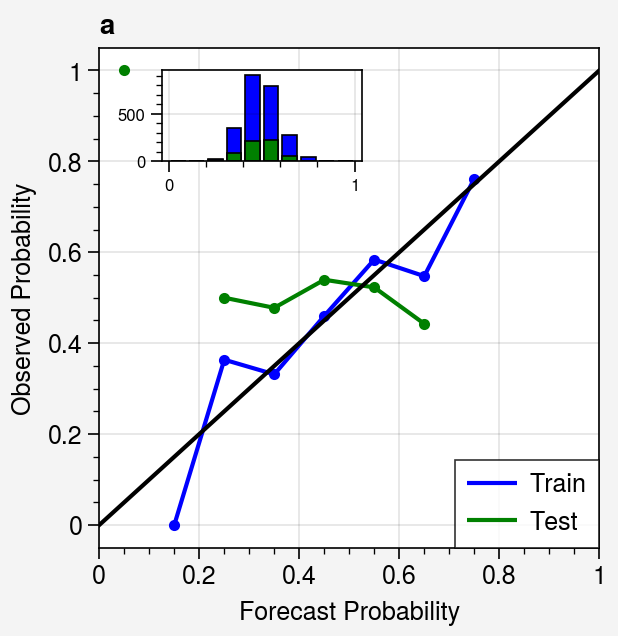

In [19]:
# Calculate reliability
rel_bins=np.arange(0,1.1,0.1)

Ypred_train=nnmodel.predict(X_train)
Ypred_test=nnmodel.predict(X_test)

Yprobs_train=nnmodel.predict_proba(X_train)
Yprobs_test=nnmodel.predict_proba(X_test)
Yverif_train=np.argmax(Y_train,axis=1)
Yverif_test=np.argmax(Y_test,axis=1)

print(Yprobs_test)

# Train
ds_verif=xr.DataArray(Yverif_train,
                     coords={'time':ds_features['time'][0:ntrain]},
                     dims=['time']).to_dataset(name='verif')
ds_probs=xr.DataArray(Yprobs_train,
                     coords={'time':ds_features['time'][0:ntrain],
                             'cat':['Lower','Upper']},
                     dims=['time','cat']).to_dataset(name='probs')
ds_train=xr.merge([ds_verif,ds_probs])

# Test
ds_verif=xr.DataArray(Yverif_test,
                     coords={'time':ds_features['time'][ntrain::]},
                     dims=['time']).to_dataset(name='verif')
ds_probs=xr.DataArray(Yprobs_test,
                     coords={'time':ds_features['time'][ntrain::],
                             'cat':['Lower','Upper']},
                     dims=['time','cat']).to_dataset(name='probs')
ds_test=xr.merge([ds_verif,ds_probs])

# Reliability

rel_train=xs.reliability(ds_train['verif']==1,ds_train['probs'].sel(cat='Upper'),dim=['time'],
                        probability_bin_edges=rel_bins)
rel_test=xs.reliability(ds_test['verif']==1,ds_test['probs'].sel(cat='Upper'),dim=['time'],
                        probability_bin_edges=rel_bins)


# Plot reliability
hs=[]
f, axs = pplt.subplots(ncols=1,nrows=1)

h=axs.plot(rel_train['forecast_probability'],rel_train,'b')
axs.plot(rel_train['forecast_probability'],rel_train,'b.')
hs.append(h)
        
h=axs.plot(rel_test['forecast_probability'],rel_test,'g')
axs.plot(rel_test['forecast_probability'],rel_test,'g.')
hs.append(h)
        
axs.format(xtickminor=True,ytickminor=True,
           xlabel='Forecast Probability',ylabel='Observed Probability',
           abc=True)
        
# Perfect reliability line
axs.plot(rel_bins,rel_bins,'k')
        
# Histogram inset
axi = axs.inset([0.125, 0.8, 0.4, 0.2], transform='data',zoom=False)
axi.bar(rel_train['samples'],color='b')
axi.bar(rel_test['samples'],color='g')

axi.format(xtickminor=True,ytickminor=True,fontsize=6)
        
# Add custom legend
axs.legend(hs, labels=['Train','Test'],ncols=1, loc='lr',title='')

In [20]:
ds_test

<xarray.Dataset>
Dimensions:  (cat: 2, time: 601)
Coordinates:
  * time     (time) datetime64[ns] 2008-06-13 2008-06-14 ... 2014-08-29
  * cat      (cat) <U5 'Lower' 'Upper'
Data variables:
    verif    (time) int64 1 1 1 1 0 0 0 0 0 1 1 0 0 ... 1 1 0 0 0 0 0 0 0 0 0 0
    probs    (time, cat) float32 0.5001 0.4999 0.5253 ... 0.4491 0.497 0.503